# Сборный проект - 2. Яндекс Практикум "Аналитик данных".

<b> Описание проекта: </b>

Необходимо разобраться в поведении пользователей мобильного приложения, которое продаёт продукты питания. 
Изучить воронку продаж и выяснить, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — "застревает" на предыдущих шагах (и на каких именно).

Также необходимо исследовать результаты A/A/B-эксперимента. По "легенде" дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. 

Необходимо выяснить, какой шрифт лучше.


<b> Ремарка: </b>

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, то можно быть уверенным в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

<b> Описание данных: </b>

Путь к файлу: /datasets/logs_exp.csv.

Каждая запись в логе — это действие пользователя, или событие. 
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Изучим общую информацию по датасету.

- Подключим библиотеки, необходимые для работы, загрузим датафрейм и выведем первые 10 строк;
- Посмотрим на данные с помощью метода info();
- Посчитаем количество пропусков в датафрейме и найдём дубликаты.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth

In [13]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [14]:
df.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [16]:
df.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [17]:
df.duplicated().sum()

413

<b> Общий вывод по разделу 1: </b>

Датафрейм содержит 244126 строк и 4 колонки. Пропуски отсутствуют. В датафрейме 413 дубликатов. Названия столбцов не соответствуют "Snake case". Столбец EventTimestamp (время события) имеет несоответствующий тип данных для времени (int64). 

## Подготовим данные.

- Заменим названия столбцов на более удобные и приведём их к "Snake case";
- Удалим дубликаты;
- Заменим тип данных столбца EventTimestamp (время события), а также добавим отдельный столбец дат.

In [18]:
df.columns = ['event_name', 'user_id', 'event_time', 'group']

In [19]:
df = df.drop_duplicates().reset_index(drop=True)

In [20]:
df['event_time'] = df['event_time'].astype('datetime64[s]')

In [21]:
df['event_date'] = df['event_time'].dt.date

In [22]:
df.head(10)

,event_name,user_id,event_time,group,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
5,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248,2019-07-25
6,OffersScreenAppear,8351860793733343758,2019-07-25 14:50:42,246,2019-07-25
7,MainScreenAppear,5682100281902512875,2019-07-25 20:14:37,246,2019-07-25
8,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247,2019-07-25
9,MainScreenAppear,5407636962369102641,2019-07-26 03:35:12,246,2019-07-26


<b> Общий вывод по разделу 2: </b>

Данные подготовлены к анализу.

## Изучим и проверим данные.

- Узнаем сколько всего событий в логе; 
- Узнаем сколько всего пользователей в логе;  
- Узнаем сколько в среднем событий приходится на пользователя; 
- Узнаем данными за какой период мы располагаем (найдём максимальную и минимальную даты); 
- Построим гистограмму по дате и времени. Проверим "полноту" данных за весь период (технически в логи новых дней по некоторым пользователям могут "доезжать" события из прошлого — это может "перекашивать данные") и определим, с какого момента данные "полные",отбросим более старые. Рассмотрим, данными за какой период времени мы располагаем на самом деле; 
- Рассмотрим, много ли событий и пользователей мы потеряли, отбросив старые данные; 
- Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

### Сколько всего событий в логе


In [23]:
df['event_name'].nunique()

5

In [24]:
df['event_name'].count()

243713

<b> Вывод: </b>

В логе 5 уникальных событий. Общее количество событий в логе - 243713.

### Сколько всего пользователей в логе

In [25]:
df['user_id'].nunique()

7551

<b> Вывод: </b>

Всего в логе 7551 пользователь.

### Сколько в среднем событий приходится на пользователя

In [26]:
round(df['event_name'].count() / df['user_id'].nunique())

32

In [27]:
df.groupby('user_id')[['event_name']].count().describe()

,event_name
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


<b> Вывод: </b>

В среднем на пользователя приходится 32 события. 

### Данными за какой период мы располагаем (найдём максимальную и минимальную даты)


In [28]:
df['event_time'].min()

Timestamp('2019-07-25 04:43:36')

In [29]:
df['event_time'].max()

Timestamp('2019-08-07 21:15:17')

<b> Вывод: </b>

Данные представлены за период с 25 июля 2019 года по 07 августа 2019.

### Построим гистограмму по дате и времени.

Проверим "полноту" данных за весь период (технически в логи новых дней по некоторым пользователям могут "доезжать" события из прошлого — это может "перекашивать данные"). 

Определим, с какого момента данные полные и отбросим более старые. Рассмотрим, данными за какой период времени мы располагаем на самом деле.

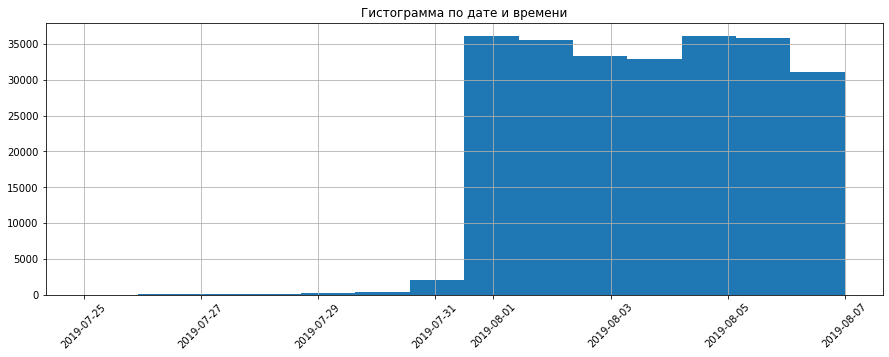

In [30]:
plt.figure(figsize =(15, 5))
df['event_date'].hist(bins=df['event_date'].nunique())
plt.title('Гистограмма по дате и времени')
plt.xticks(rotation=45)
plt.show()

<b> Вывод: </b>

Как видно из гистограммы, в период с 25.07.2019 по 31.07.2019 данные практически отсутствуют. Будем считать их неполными и отбросим.

### Рассмотрим, много ли событий и пользователей мы потеряли, отбросив старые данные

In [31]:
df_new = df.query('event_date >= datetime(2019, 8, 1).date()')

In [32]:
df['event_name'].count() - df_new['event_name'].count()

2826

In [33]:
round(df_new['event_name'].count() / df['event_name'].count() * 100, 2)

98.84

In [34]:
df['user_id'].nunique() - df_new['user_id'].nunique()

17

In [35]:
round(df_new['user_id'].nunique() / df['user_id'].nunique() * 100, 2)

99.77

<b> Вывод: </b>

После отбрасывания неполных данных мы потеряли 2826 событий, вследствии чего, у нас осталось 98.84 % от первоначальных данных и мы потеряли 17 пользователей, вследствии чего, у нас осталось 99.77 % от первоначальных данных.

### Проверим, что у нас есть пользователи из всех трёх экспериментальных групп



In [36]:
df_new.groupby('group').agg({'user_id': 'nunique'}).reset_index()

,group,user_id
0,246,2484
1,247,2513
2,248,2537


<b> Вывод: </b>

В очищенных данных присутствуют пользователи из всех трёх экспериментальных групп.

<b> Общий вывод по разделу 3: </b>

Рассмотрев распределение данных по дате, мы отсеили неполные данные (период с 25.07.2019 по 31.07.2019). Последующая проверка показала, что процент отброшенных данных мал, и в очищенных данных присутствуют пользователи из всех трёх экспериментальных групп.  

## Изучим воронку событий.

- Посмотрим, какие события есть в логах, как часто они встречаются и отсортируем их по частоте; 
- Посчитаем, сколько пользователей совершали каждое из этих событий и отсортируем события по числу пользователей;
- Посчитаем долю пользователей, которые хоть раз совершали событие; 
- Предположим, в каком порядке происходят события, все ли они выстраиваются в последовательную цепочку, какие события не нужно учитывать при расчёте воронки; 
- По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем,то есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B);
- Выясним на каком шаге теряете больше всего пользователей и какая доля пользователей доходит от первого события до оплаты.

### Посмотрим, какие события есть в логах, как часто они встречаются и отсортируем их по частоте.

In [37]:
df_new['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

<b> Вывод: </b>

Всего 5 событий:
- MainScreenAppear - просмотр главной страницы;
- OffersScreenAppear - просмотр страницы предложений;
- CartScreenAppear - просмотр корзины;
- PaymentScreenSuccessful - переход на страницу оплаты;
- Tutorial - обучение.


### Посчитаем, сколько пользователей совершали каждое из этих событий и отсортируем события по числу пользователей.

In [38]:
df_new.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()

,event_name,user_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


<b> Вывод: </b>

Больше всего пользователей просматривало главную страницу. Далее, по ходу выполнения операций в приложении количество пользователей снижается. Обучение проходит небольшое количество пользователей. 

### Посчитаем долю пользователей, которые хоть раз совершали событие.


In [39]:
# Создадим временную таблицу и добавим к ней колонку с процентами
t = df_new.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
t['percent'] = t['user_id'] / df_new['user_id'].nunique() * 100
t

,event_name,user_id,percent
0,MainScreenAppear,7419,98.473586
1,OffersScreenAppear,4593,60.963632
2,CartScreenAppear,3734,49.561986
3,PaymentScreenSuccessful,3539,46.973719
4,Tutorial,840,11.149456


<b> Вывод: </b>

Только половина пользователей добирается до корзины, и ещё меньше до оплаты.

### Предположим, в каком порядке происходят события, все ли они выстраиваются в последовательную цепочку, какие события не нужно учитывать при расчёте воронки.

Ранее мы рассмотрели, какие события есть в логах.

In [40]:
df_new['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

<b> Вывод: </b>

Исходя из привычной логики совершения покупок, можно смело предположить, что порядок событий именно такой:
- MainScreenAppear - просмотр главной страницы;
- OffersScreenAppear - просмотр страницы предложений;
- CartScreenAppear - просмотр корзины;
- PaymentScreenSuccessful - переход на страницу оплаты.

Обучение является необязательным действием и его можно исключить из воронки.

### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки 

(от числа пользователей на предыдущем,то есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B).


In [41]:
# Удалим событие Tutorial
df_new = df_new.query('event_name != "Tutorial"')

In [42]:
# Создадим временную таблицу и добавим к ней колонку с процентами
t = df_new.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by = 'user_id', ascending = False).reset_index()
t

,event_name,user_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


In [43]:
t['percent'] = round(t['user_id'] / t['user_id'].shift(), 2)
t

,event_name,user_id,percent
0,MainScreenAppear,7419,NaN
1,OffersScreenAppear,4593,0.62
2,CartScreenAppear,3734,0.81
3,PaymentScreenSuccessful,3539,0.95


<b> Вывод: </b>

На шаге просмотра страницы предложений теряется больше всего пользователей.

### Выясним на каком шаге теряете больше всего пользователей и какая доля пользователей доходит от первого события до оплаты.

In [44]:
funnel_t = t

In [45]:
funnel_t

,event_name,user_id,percent
0,MainScreenAppear,7419,NaN
1,OffersScreenAppear,4593,0.62
2,CartScreenAppear,3734,0.81
3,PaymentScreenSuccessful,3539,0.95


In [46]:
from plotly import graph_objects as go

fig = go.Figure(go.Funnel(
    y= funnel_t['event_name'],
    x= funnel_t['user_id'],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.update_layout(yaxis_title = 'event_name')

fig.show()

In [47]:
round(3539/7419*100, 2)

47.7

<b> Вывод: </b>

Всего 47.7 % пользователей доходит от первого шага до покупки.

<b> Общий вывод по разделу 4: </b>

В воронку событий входит 4 последовательных события:
- MainScreenAppear - просмотр главной страницы;
- OffersScreenAppear - просмотр страницы предложений;
- CartScreenAppear - просмотр корзины;
- PaymentScreenSuccessful - переход на страницу оплаты.

Больше всего пользователей просматривало главную страницу.
На следующем шаге - OffersScreenAppear - просмотр страницы предложений теряется больше всего пользователей.
И только 47.7 % пользователей доходит от первого шага до покупки.


## Изучим результаты эксперимента

- Посчитаем, сколько пользователей в каждой экспериментальной группе;
- Проверим корректность всех механизмов и расчётов;
- Выберем самое популярное событие; 
- Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп; 
- Посчитаем долю пользователей, совершивших это событие; 
- Проверим, будет ли отличие между группами статистически достоверным; 
- Проделаем то же самое для всех других событий; 
- Проверим, можно ли сказать, что разбиение на группы работает корректно;
- Аналогично поступим с группой с изменённым шрифтом, сравним результаты с каждой из контрольных групп в отдельности по каждому событию; 
- Сравним результаты с объединённой контрольной группой.

In [48]:
# Для удобства переименуем группы

def rename_group(group):
    if group == 246:
        return 'A1'
    elif group == 247:
        return 'A2'
    elif group == 248:
        return 'B'

df_new['group'] = df_new['group'].apply(rename_group)

### Посчитаем, сколько пользователей в каждой экспериментальной группе.

In [49]:
total_users = df_new.groupby('group')['user_id'].nunique()
total_users

group
A1    2483
A2    2512
B     2535
Name: user_id, dtype: int64

<b> Вывод: </b>

В контрольных группах:
- A1(246) — 2483 пользователей;
- A2(247) — 2512 пользователей.

В экспериментальной группе:
- B(248) — 2535 пользователей.

### A/A-тест. 

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

#### Критерии успешного A/A-теста:

- Количество пользователей в различных группах различается не более, чем на 1% или 0.5%
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

In [50]:
group_A1 = df_new[df_new['group'] == 'A1']['user_id'].nunique()
group_A2 = df_new[df_new['group'] == 'A2']['user_id'].nunique()
round(1 - group_A1 / group_A2, 2)

0.01

In [51]:
len(np.intersect1d(df_new.query('group == "A1"')['user_id'].unique(), df_new.query('group == "A2"')['user_id'].unique()))

0

<b> Вывод: </b>

Количество пользователей в группах различается менее, чем на 0.5%. Пересечений в группах нет.

#### Выберем самое популярное событие и посчитаем число пользователей, совершивших это событие в каждой из контрольных групп.

In [52]:
# Создадим временную таблицу
t = df_new.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').sort_values(by='A1', ascending=False).drop('B', axis=1)
t

group,A1,A2
event_name,,
MainScreenAppear,2450,2476
OffersScreenAppear,1542,1520
CartScreenAppear,1266,1238
PaymentScreenSuccessful,1200,1158


<b> Вывод: </b>

Cамое популярное событие - MainScreenAppear - просмотр главной страницы.

#### Посчитаем долю пользователей, совершивших это событие.

In [53]:
t['percent_A1'] = round(t['A1'] / total_users['A1'], 2)
t['percent_A2'] = round(t['A2'] / total_users['A2'], 2)
t_MainScreenAppear = t.query('event_name == "MainScreenAppear"')
t_MainScreenAppear

group,A1,A2,percent_A1,percent_A2
event_name,,,,
MainScreenAppear,2450,2476,0.99,0.99


<b> Вывод: </b>

В обоих случаях доля пользователей, совершавших событие - MainScreenAppear - просмотр главной страницы, составляет 99%.

#### Проверим, будет ли отличие между группами статистически достоверным.

Сформируем гипотезы:

- Н0: между долями нет статистически значимой разницы;
- Н1: между долями есть статистически значимые различия.

Создадим функцию для проведения z-теста для проверки гипотезы о равенстве долей:

- group1, group2 - тестируемые группы;
- event_name - событие.

In [54]:
def z_test (group1, group2, event_name):

    # критический уровень статистической значимости
    alpha = .05 # критический уровень статистической значимости
     
    #значения выборок на уровне тестируемого события
    successes1 = t.loc[event_name, group1]
    successes2 = t.loc[event_name, group2]
    
    #первоначальные значения выборок 
    total_users1 = total_users[group1] 
    total_users2 = total_users[group2]

    # пропорция успехов в первой группе:
    p1 = successes1/total_users1
    
    # пропорция успехов во второй группе:
    p2 = successes2/total_users2

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (total_users1 + total_users2)

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total_users1 + 1/total_users2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу, между долями есть статистически значимые различия')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, между долями нет статистически значимой разницы')

In [55]:
z_test ('A1', 'A2', 'MainScreenAppear')

p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, между долями нет статистически значимой разницы


<b> Вывод: </b>

По результатам проведения z-теста для проверки гипотезы о равенстве долей - нет оснований считать доли разными.

#### Проделаем то же самое для всех других событий.

In [56]:
z_test ('A1', 'A2', 'OffersScreenAppear')

p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, между долями нет статистически значимой разницы


In [57]:
z_test ('A1', 'A2', 'CartScreenAppear')

p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, между долями нет статистически значимой разницы


In [58]:
z_test ('A1', 'A2', 'PaymentScreenSuccessful')

p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, между долями нет статистически значимой разницы


<b> Вывод: </b>

При z - тесте каждого события нет оснований считать доли разными. Разбиение на группы работает корректно.

### A/B-тест.

Аналогично поступим с группой с изменённым шрифтом, сравним результаты с каждой из контрольных групп в отдельности по каждому событию.

In [59]:
# Создадим временную таблицу
t = df_new.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').sort_values(by='A1', ascending=False)
t

group,A1,A2,B
event_name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181


In [60]:
z_test ('A1', 'B', 'MainScreenAppear')

p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, между долями нет статистически значимой разницы


In [61]:
z_test ('A1', 'B', 'OffersScreenAppear')

p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, между долями нет статистически значимой разницы


In [62]:
z_test ('A1', 'B', 'CartScreenAppear')

p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, между долями нет статистически значимой разницы


In [63]:
z_test ('A1', 'B', 'PaymentScreenSuccessful')

p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, между долями нет статистически значимой разницы


In [64]:
z_test ('A2', 'B', 'MainScreenAppear')

p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, между долями нет статистически значимой разницы


In [65]:
z_test ('A2', 'B', 'OffersScreenAppear')

p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, между долями нет статистически значимой разницы


In [66]:
z_test ('A2', 'B', 'CartScreenAppear')

p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, между долями нет статистически значимой разницы


In [67]:
z_test ('A2', 'B', 'PaymentScreenSuccessful')

p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, между долями нет статистически значимой разницы


<b> Вывод: </b>

При сравнении группы с изменённым шрифтом, с каждой из контрольных групп в отдельности по каждому событию, по результатам z - теста нет оснований считать доли разными.

### Сравним результаты с объединённой контрольной группой.

In [68]:
# Добавим к временной таблице колонку с объединённой контрольной группой
t['A1+A2'] = t['A1'] + t['A2']
t

group,A1,A2,B,A1+A2
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


In [69]:
# Добавим сумму пользователей объединённой контрольной группой
total_users = df_new.groupby('group')['user_id'].nunique()
total_users['A1+A2'] = total_users['A1'] + total_users['A2']
total_users

group
A1       2483
A2       2512
B        2535
A1+A2    4995
Name: user_id, dtype: int64

In [70]:
z_test ('A1+A2', 'B', 'MainScreenAppear')

p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, между долями нет статистически значимой разницы


In [71]:
z_test ('A1+A2', 'B', 'OffersScreenAppear')

p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, между долями нет статистически значимой разницы


In [72]:
z_test ('A1+A2', 'B', 'CartScreenAppear')

p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, между долями нет статистически значимой разницы


In [73]:
z_test ('A1+A2', 'B', 'PaymentScreenSuccessful')

p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, между долями нет статистически значимой разницы


<b> Вывод: </b>

При сравнении группы с изменённым шрифтом, с  объединённой контрольной группой по каждому событию, по результатам z - теста нет оснований считать доли разными.

<b> Общий вывод по разделу 5: </b>

Для проведения z-теста на равенство долей групп были сформулированы гипотезы:
- Н0: между долями есть значимая разница;
- Н1: нет оснований считать доли разными.

Во всех сравниваемых группах, по всем событиям - нет оснований считать доли разными.

## Заключение.

По результатам анализа дпнных о поведении пользователей мобильного приложения выявлены следующие факты:
1. В воронку событий входит 4 последовательных события:
- MainScreenAppear - просмотр главной страницы;
- OffersScreenAppear - просмотр страницы предложений;
- CartScreenAppear - просмотр корзины;
- PaymentScreenSuccessful - переход на страницу оплаты.

Больше всего пользователей просматривало главную страницу. На следующем шаге - OffersScreenAppear - просмотр страницы предложений теряется больше всего пользователей. И только 47.7 % пользователей доходит от первого шага до покупки.

2. Изучение результатов эксперимента по смене шрифта говорит о том, что разницы в поведении пользователей в зависимости от шрифта нет. Если работа по замене шрифта не несёт больших экономических и/или трудовых издержек, то шрифт можно заменить.
 
Для проведения z-теста на равенство долей групп были сформулированы гипотезы:
- Н0: между долями есть значимая разница;
- Н1: нет оснований считать доли разными.

Критический уровень статистической значимости был принят равным 0.05. 

Было проведено 16 проверок статистических гипотез.

Во всех сравниваемых группах, по всем событиям - между долями нет статистически значимой разницы.